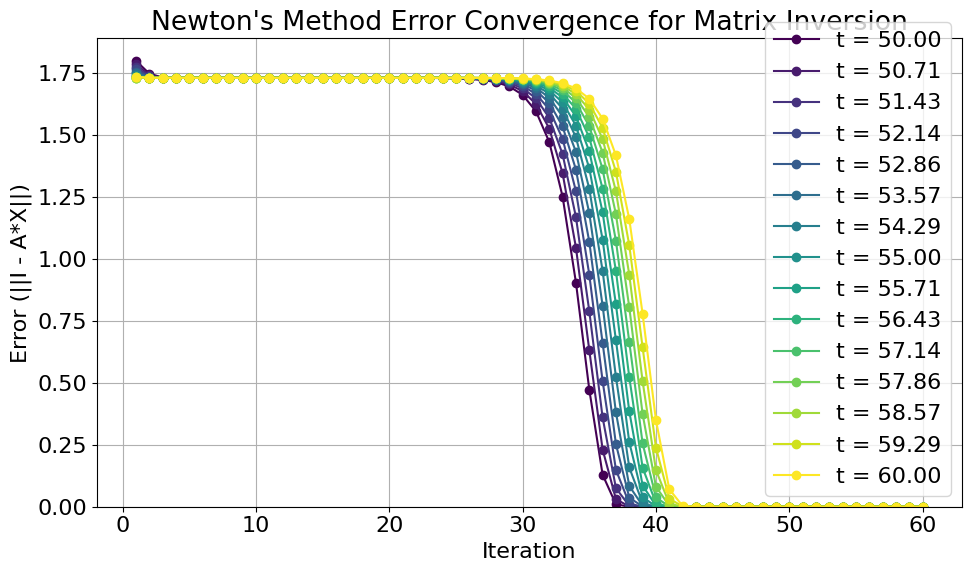

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

tan_half_bool = False

def newton_matrix_inversion(A, iterations=60, tol_diverge=1e10):
    """
    Uses Newton's method to approximate the inverse of matrix A.
    The iteration is: X_{k+1} = X_k (2I - A X_k)
    
    Error is defined as the magnitude difference: ||I - A * X||
    If the error grows above tol_diverge, we stop the iterations.
    """
    n = A.shape[0]
    I = np.eye(n, dtype=A.dtype)
    # Common initial guess.
    X = A.T / (np.linalg.norm(A, 1) * np.linalg.norm(A, np.inf))
    
    errors = []
    for k in range(iterations):
        err = np.linalg.norm(I - A @ X)
        errors.append(err)
        # Check for divergence.
        if k > 0 and err > tol_diverge:
            # Fill remaining iterations with the current (diverging) error value.
            errors += [err] * (iterations - k)
            #print(f"Iteration {k}: error grew too large ({err:.2e}). Stopping further iterations.")
            break
        X = X @ (2*I - A @ X)
    return X, errors

import numpy as np

def evaluate_time_evolved_polynomial(t, S=0, tan_half=False):
    """
    Evaluates the polynomial:
      (((((((( (B - 90*I)*B + 3960*I)*B - 110880*I)*B + 2162160*I)
             *B - 30270240*I)*B + 302702400*I)*B - 2075673600*I)
             *B + 8821612800*I)*B - 17643225600*I
    on the matrix A = 1j*t*(B*2**(-S)).

    Parameters:
      t         : A real scalar parameter.
      S         : A scaling parameter (default 0).
      tan_half  : If True, t is first mapped onto the unit circle using the
                  tangent half-angle substitution:
                      t -> ( (1-t**2)/(1+t**2) + i*(2*t/(1+t**2)) )
                  (default: False).

    Returns:
      poly      : The evaluated matrix (result of the polynomial).
    """
    B = np.array([
        [0,    0,    0, 0],
        [0, -0.5,  0.5, 0],
        [0,  0.5, -0.5, 0],
        [0,    0,    0, 0]
    ], dtype=np.complex128)
    
    # Optionally map t onto the unit circle using the tangent half-angle substitution.
    if tan_half:
        theta = 2 * np.arctan(t)
    else:
        theta = t
    
    A = (1j * t * (B)) * 2**S
    n = A.shape[0]
    I = np.eye(n, dtype=A.dtype)
    
    # Evaluate the polynomial using Horner's method.

    #Degree 3 Poly
    #poly = A**3 - 12*A**2 +60*A - 120*I

    #Degree 9 Poly
    poly = A - 90 * I
    poly = poly @ A + 3960 * I
    poly = poly @ A - 110880 * I
    poly = poly @ A + 2162160 * I
    poly = poly @ A - 30270240 * I
    poly = poly @ A + 302702400 * I
    poly = poly @ A - 2075673600 * I
    poly = poly @ A + 8821612800 * I
    poly = poly @ A - 17643225600 * I
    
    return poly


# Use fewer time values for a clearer plot.
times = np.linspace(50, 60, 15)
results = [evaluate_time_evolved_polynomial(t, S=0,tan_half=tan_half_bool) for t in times]

# Collect error histories from Newton's inversion.
all_errors = []
for mat in results:
    _, errors = newton_matrix_inversion(mat, iterations=60)
    all_errors.append(errors)

# Plot the error history.
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(times)))
for i, errors in enumerate(all_errors):
    iterations = np.arange(1, len(errors) + 1)  # starting at iteration 1
    plt.plot(iterations, errors, marker='o', color=colors[i],
             label=f"t = {times[i]:.2f}")
    
plt.xlabel("Iteration")
plt.ylabel("Error (||I - A*X||)")
plt.title("Newton's Method Error Convergence for Matrix Inversion")

# Use a linear y-scale and force the y-axis to start at 0.
plt.ylim(bottom=0)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


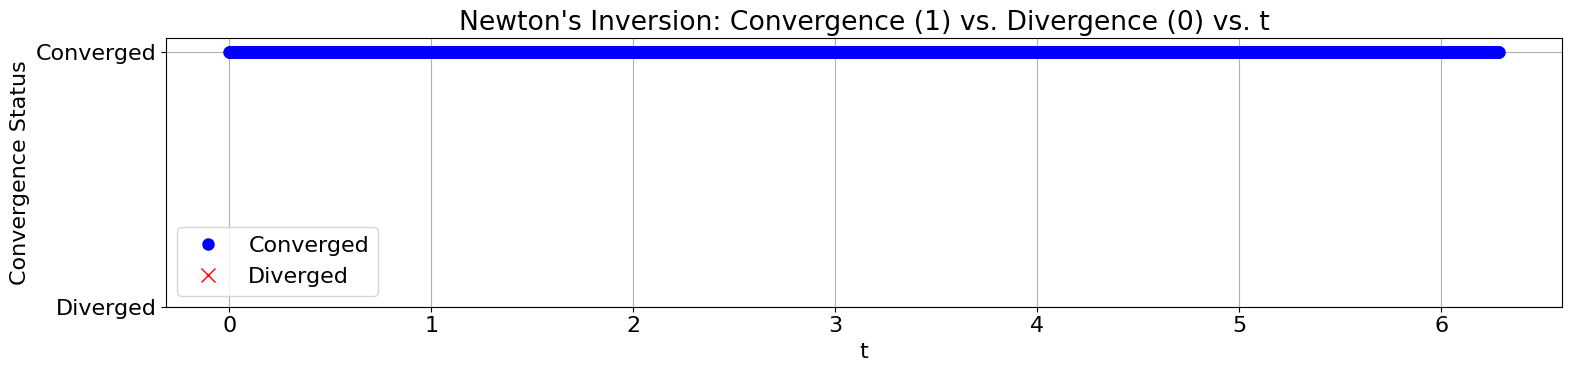

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# --- Main testing/plotting section ---

# Settings: number of test t-values and tolerance for convergence.
num_test_times = 5000  # You can increase this number to test more t-values.
tol = 0.01           # Tolerance on the final error to declare convergence.

# Generate t values (here, we test from t = 0 to 48*pi).
times = np.linspace(0, 2* np.pi, num_test_times)

# For each t, compute the matrix and run Newton's inversion.
results = [evaluate_time_evolved_polynomial(t, S=5,tan_half=tan_half_bool) for t in times]
all_errors = [newton_matrix_inversion(mat, iterations=60)[1] for mat in results]

# Determine convergence: True if the final error is below tol, False otherwise.
convergence_status = np.array([errors[-1] < tol for errors in all_errors])

# Separate times into those that converged and those that diverged.
times_converged = times[convergence_status]
times_diverged  = times[~convergence_status]

# Plot convergence status versus t.
plt.figure(figsize=(16, 4))
plt.plot(times_converged, np.ones_like(times_converged), 'bo', markersize=8, label='Converged')
plt.plot(times_diverged, np.zeros_like(times_diverged), 'rx', markersize=10, label='Diverged')

plt.xlabel("t")
plt.ylabel("Convergence Status")
plt.title("Newton's Inversion: Convergence (1) vs. Divergence (0) vs. t")
plt.yticks([0, 1], ['Diverged', 'Converged'])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


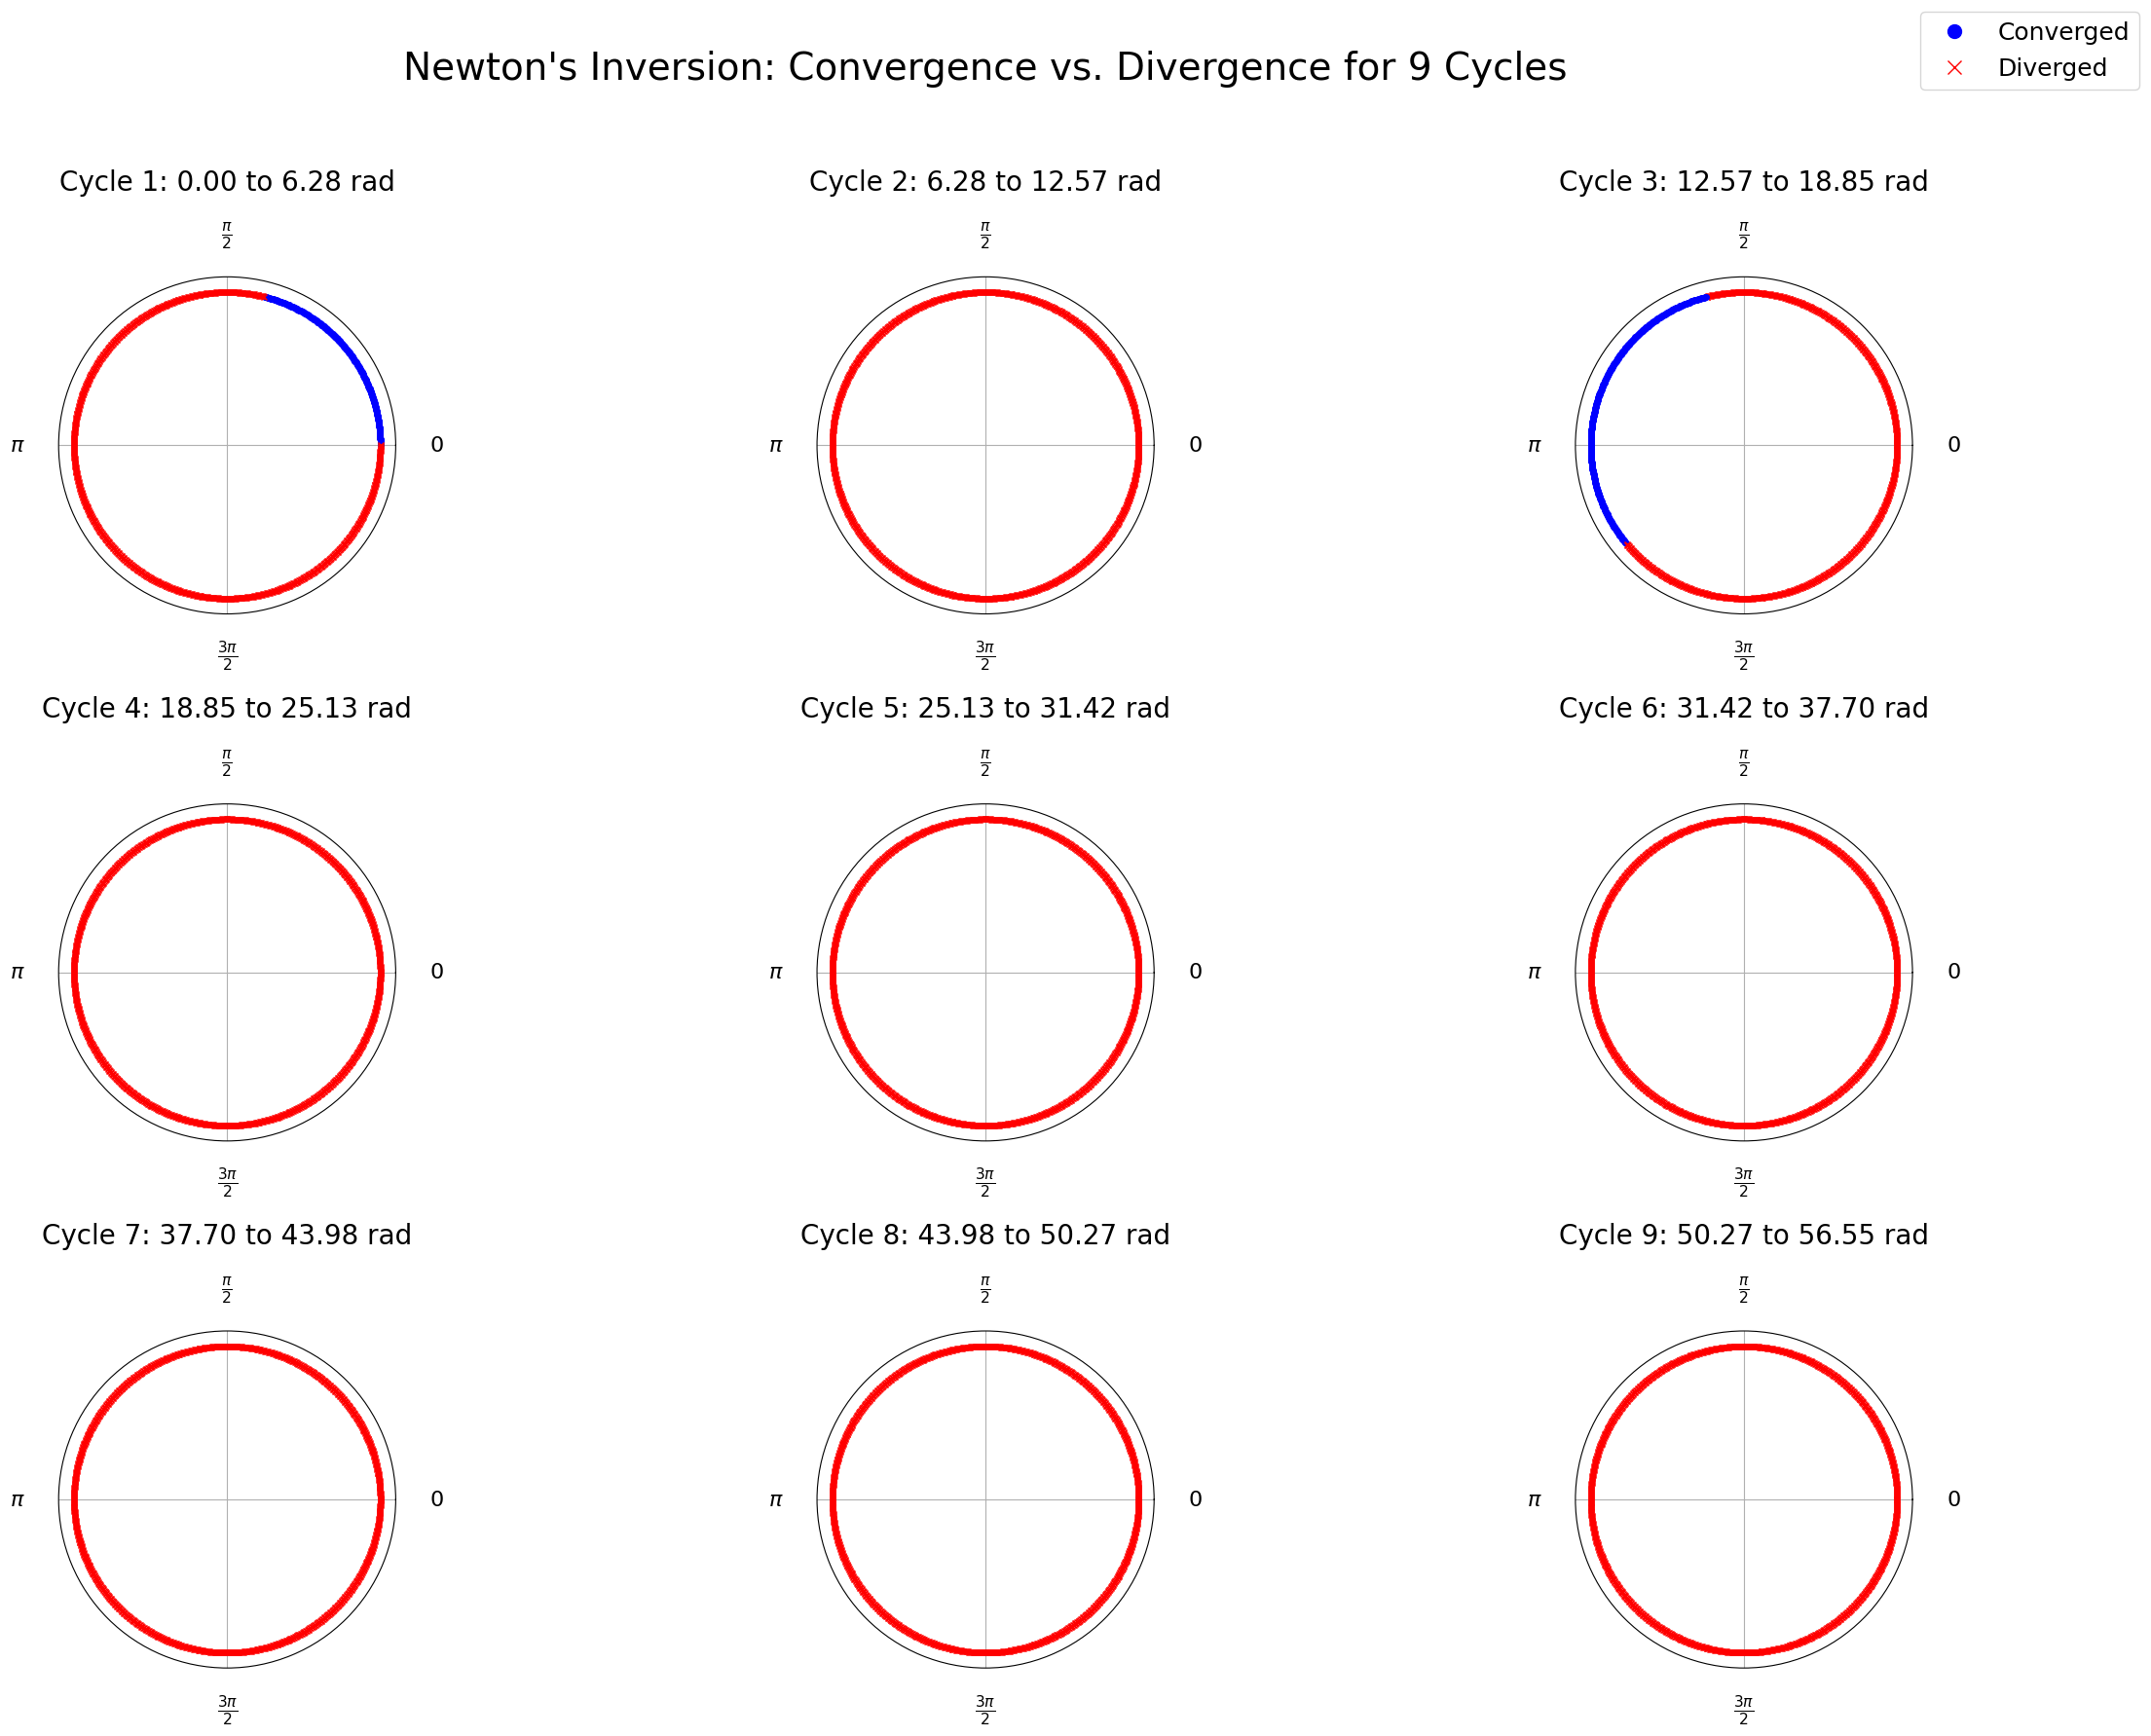

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- Assumes evaluate_time_evolved_polynomial and newton_matrix_inversion are defined ---

# Settings
num_cycles = 9                   # Total number of cycles (each cycle covers 2π in t)
num_test_times_per_cycle = 1000  # Number of t values per cycle
tol = 0.01                        # Convergence tolerance

# Create 9 polar subplots arranged in a 3 x 3 grid.
fig, axes = plt.subplots(3, 3, subplot_kw={'projection': 'polar'}, figsize=(24, 18))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Update global font size.
plt.rcParams.update({'font.size': 16})

for i in range(num_cycles):
    # Define the time interval for the current cycle.
    t_min = 2 * np.pi * i
    t_max = 2 * np.pi * (i + 1)
    # Generate t values for this cycle.
    times = np.linspace(t_min, t_max, num_test_times_per_cycle)
    
    # Evaluate the matrix and run Newton's iteration for each t.
    results = [evaluate_time_evolved_polynomial(t, S=0,tan_half=tan_half_bool) for t in times]
    all_errors = [newton_matrix_inversion(mat, iterations=30)[1] for mat in results]
    
    # Determine convergence: 1 if final error < tol, else 0.
    convergence_status = [1 if errors[-1] < tol else 0 for errors in all_errors]
    
    ax = axes[i]
    # Plot each point at radius = 1; use t mod 2π so the angle is always in [0, 2π).
    for t, status in zip(times, convergence_status):
        angle = t % (2 * np.pi)
        if status == 1:
            ax.plot(angle, 1, 'bo', markersize=4)
        else:
            ax.plot(angle, 1, 'rx', markersize=4)
    
    # Customize the polar plot.
    ax.set_rmax(1.1)
    ax.set_rticks([])  # Hide radial ticks for clarity.
    
    # Set and customize the angular ticks.
    xticks = [0, np.pi/2, np.pi, 3*np.pi/2]
    xtick_labels = [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$"]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels, fontsize=16, fontweight='bold')
    ax.tick_params(axis='x', pad=20, labelsize=16)  # Increase padding for tick labels
    
    # Increase title pad to 60 to move it further away from the top tick.
    ax.set_title(f"Cycle {i+1}: {t_min:.2f} to {t_max:.2f} rad", va='bottom', pad=60, fontsize=20)

# Add an overall title to the figure.
fig.suptitle("Newton's Inversion: Convergence vs. Divergence for 9 Cycles", fontsize=28, y=0.97)

# Create a global legend with proper markers for both statuses.
legend_elements = [
    Line2D([0], [0], marker='o', color='b', label='Converged', markersize=10, linestyle='None'),
    Line2D([0], [0], marker='x', color='r', label='Diverged', markersize=10, linestyle='None')
]
fig.legend(handles=legend_elements, loc='upper right', fontsize=18)

# Adjust layout to allow space for the overall title.
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
